## Metrics Prep

- [ ] BLEU score
- [ ] Precision
- [ ] Recall
- [ ] ROC Curve
- [ ] F1 Score
- [ ] Perplexity






### What Might be in AI Coding
- K-means clustering, k-NN classification, or even a 2D convolution operation from scratch
- precision and recall, Intersection over Union (IoU) for object detection, or implementing cross-entropy loss calculation
- ROC curve and AUC, or ensuring you understand log-sum-exp tricks for stability
- implement a forward pass for a layer or small neural net (such as coding a convolution or a simple feed-forward network) and discuss how to compute gradients.
- mini backpropagation
    - initializing parameters, looping or using matrix ops for computations, zeroing out gradients between iterations
- gradient accumulation
- why we zero gradients before backprop in PyTorch
- modify a training loop to run on multiple GPUs or how to handle very large input data in chunks.
- writing a small snippet using torch tensors or explaining how autograd works
- how to create a custom data loader, how to use PyTorch’s neural network modules, or how to calculate gradients manually could be assessed.


In [2]:
import numpy as np

In [25]:
import torch

In [1]:
import transformers

In [95]:
import matplotlib.pyplot as plt

In [58]:
import sklearn.metrics as skm

### Binary Classification Data

In [42]:
def error_counts(preds, targets):
    n_tp = ((targets == 1) * (preds == 1)).sum()
    n_fp = ((targets == 0) * (preds == 1)).sum()
    n_tn = ((targets == 0) * (preds == 0)).sum()
    n_fn = ((targets == 1) * (preds == 0)).sum()
    return {"tp": n_tp, "fp": n_fp, "tn": n_tn, "fn": n_fn}

In [18]:
n = 100
y_gold = np.random.randint(low=0, high=2, size=n)

In [10]:
probs = np.random.rand(n)

In [14]:
threshold = 0.57
y_pred = np.array([0 if p < threshold else 1 for p in probs])

In [43]:
results_dict = error_counts(y_pred, y_gold)

In [44]:
results_dict

{'tp': 26, 'fp': 18, 'tn': 24, 'fn': 32}

### Precision

Precision = TP / (TP + FP)

Q: is there a notion of precision in multi-class classification ? 


In [46]:
def precision(results):
    prec = results["tp"] / (results["tp"] + results["fp"])
    return prec

In [61]:
my_precision = precision(results_dict)

In [62]:
sk_precision = skm.precision_score(y_gold, y_pred)

In [63]:
print("correct:", my_precision == sk_precision)

correct: True


### Recall

Recall = TP / (TP + FN)

In [48]:
def recall(results):
    rec = results["tp"] / (results["tp"] + results["fn"])
    return rec

In [64]:
my_recall = recall(results_dict)

In [65]:
sk_recall = skm.recall_score(y_gold, y_pred)

In [66]:
print("correct:", my_recall == sk_recall)

correct: True


### F1 Score

Harmonic mean of precision and recall. In the sample two number case, harmonic mean can be written as:

$$H = 2 * \frac{(x_1 * x_2)}{x_1 + x_2}$$


- Number is low unless both precision & recall are high
- Assumes you care equally about false positives & false negatives



In [54]:
def f1_score(results):
    prec = precision(results)
    rec  = recall(results)
    return 2 * (prec * rec) / (prec + rec)

In [69]:
my_f1 = f1_score(results_dict)

In [67]:
sk_f1 = skm.f1_score(y_gold, y_pred)

In [71]:
print("correct:", sk_f1 == my_f1)

correct: True


### ROC Curve

* X-axis: False Positive rate (FPR) = FP / (FP + TN)
    * Out of all negative examples, how many did you predict as positive
* Y-axis: True Positive Rate (TPR) = TP / (TP + FN) = Recall
    * Out of all positive examples, how many did you predict as positive


Interpretation: 
* A model that does a perfect job separating positive and negative cases will get a TPR = 1.0 and a FPR = 0.0

Ways ROC curves can be gamed:
* Imbalanced dataset e.g., where positives are very rare, will make an ROC curve look good when it's not
* Treates flase positives and false negatives as equally bad. In real world tasks (e.g., spam detection) these are not equally bad 

In [72]:
# positive is score >= threshold

In [91]:
y_target = y_gold

In [80]:
y_scores = probs

In [92]:
def plot_roc_curve(y_scores, y_target):
    # FPR = FP / (FP + TN)
    # TPR = TP / (TP + FN)
    thresholds = sorted(list(set(probs)), reverse=True) + [float("-inf")]
    tpr = []
    fpr = []
    
    for t in thresholds:
        preds = np.zeros_like(y_scores)
        pos_idx = y_scores >= t 
        preds[pos_idx] = 1
        results = error_counts(preds, y_target)
        tpr.append(results["tp"] / (results["tp"] + results["fn"]))
        fpr.append(results["fp"] / (results["fp"] + results["tn"]))
    return np.array(fpr), np.array(tpr)

In [121]:
xs, ys = plot_roc_curve(probs, y_gold)

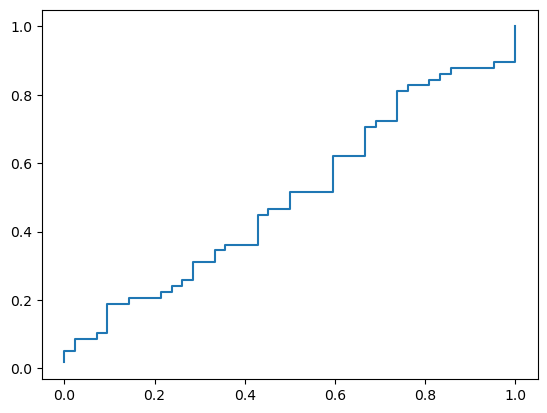

In [97]:
plt.plot(xs, ys)

In [98]:
sk_xs, sk_ys, _ = skm.roc_curve(y_gold, probs)

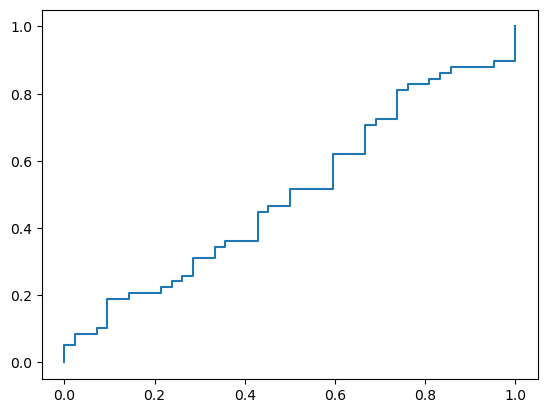

In [99]:
plt.plot(sk_xs, sk_ys)

### AUC 



In [122]:
def auc(fpr, tpr):
    """
    This is using the trapezoid rule and assumes FPR / TPR are sorted in increasing order by FPR 

    Trapezoid area = h * (a + b)/2 
    """
    # each of these range from 0 to one
    total = 0
    for i in range(len(fpr)-1):
        # we assume it's of height y1 until we hit x2
        x1 = fpr[i]
        x2 = fpr[i+1]
        y1 = tpr[i]
        y2 = tpr[i+1]
        total += (x2 - x1) * (y1 + y1) * 0.5
    return total

In [123]:
auc(xs, ys)

0.501231527093596

### Perplexity 

$$ 2^{- \frac{1}{n} \sum_{i=1}^{n} \log p(x_i | x_{i-1}, ...,) }$$ 


- Min value: 1 
- Max value: inf
- lower is better
- As uncertain as if the model is uniformly guessing amount perplexity choices

In [11]:
model = transformers.AutoModelForCausalLM.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="./pythia-70m-deduped/step3000",
)

tokenizer = transformers.AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="./pythia-70m-deduped/step3000",
)

inputs = tokenizer("Hello, I am bob", return_tensors="pt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [79]:
def ppl(logits, y_target):
    with torch.no_grad():
        logits = logits - logits.max()
        probs = torch.exp(logits) / torch.sum(torch.exp(logits), dim=-1).unsqueeze(dim=-1)
        # we exclude the last pred b/c we have nothing to predict there
        target_probs = torch.gather(probs[0][:-1], index=y_target.view(-1, 1), dim=1)
        perplexity = torch.exp(-1/target_probs.shape[0] * torch.log(target_probs).sum())
    return perplexity

In [12]:
model_out = model(**inputs)

In [80]:
logits = model_out["logits"]

In [81]:
ppl(model_out["logits"], inputs["input_ids"][0][1:].view(-1, 1))

tensor(149.5902)

### WER 

In [7]:
def wer(pred, target):
    """
    Computes the word error rate between the prediction and the transcript
    
    Uses levenshtein distance between reference and predicted seq, normalized by the number of words in the reference
    """
    n_pred = len(pred)
    n_target = len(target)


    dp = [[0]*(n_pred+1) for i in range(n_target+1)]

    for i in range(1, n_target+1):
        for j in range(1, n_pred+1):
            # -1 b/c zero indexed 
            if target[i-1] == pred[j-1]:
                sub = 0
            else:
                sub = 1
            
            dp[i][j] = min(dp[i][j-1] + 1, dp[i-1][j] + 1, dp[i-1][j-1] + sub)

    edit_dist = dp[n_target][n_pred]
    return edit_dist / n_target

In [11]:
wer_pred = "hi my name is bob and i love to run".split(" ")
wer_target = "hi my name is dave and i love running".split(" ")

In [12]:
wer(wer_pred, wer_target)

0.3333333333333333